Do some calculations for the windowed model.

In [119]:
# where are individual predictions stored?
predictions_folder = '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/'

save_dats_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/paper1/dats/'

# which set of test instances to use
test_file_dir = '/Users/jnaiman/Dropbox/wwt_image_extraction/OCRPostCorrection/alignments/'
#test_file = 'test_file_small_words_pageLevel.csv'
test_file = 'test_file_small_words_pageLevel_old.csv'

In [65]:
from glob import glob
import pandas as pd
import fastwer
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib

In [115]:
def get_iqr(df_byt5_words,col):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

def get_iqr_by_value(colvalue):
    Q3 = np.quantile(colvalue, 0.75)
    Q1 = np.quantile(colvalue, 0.25)
    IQR = Q3 - Q1
    return IQR

def get_stats(df_byt5_words,col, round_val = 2, print_nans=False):
    colvalue = df_byt5_words[col]
    colvalue = colvalue[~np.isnan(colvalue)]
    # how many nan's
    if print_nans: print('# NaNs =', len(df_byt5_words[col])-len(colvalue))
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val)

def get_improvement_stats(df_byt5_words,col_before, col_after, round_val = 2):
    colvalueb = df_byt5_words[col_before]
    colvalueb = colvalueb[~np.isnan(colvalueb)]
    colvaluea = df_byt5_words[col_after]
    colvaluea = colvaluea[~np.isnan(colvaluea)]
    mask = colvalueb != 0
    colvalue = 100*(1-colvaluea[mask]/colvalueb[mask])
    med = colvalue.median()
    mea = colvalue.mean()
    std = colvalue.std()
    iqr = get_iqr_by_value(colvalue)
    return round(mea,round_val), round(med,round_val), round(std,round_val), round(iqr,round_val) 

def save_dat(fname,data,formatting = None):
    if formatting is not None:
        all_arts = "{:,}".format(successful_align_pages)
    else:
        all_arts = data
    with open(fname, 'w') as f:
        print(all_arts, file=f,end='')

In [49]:
test_data = pd.read_csv(test_file_dir+test_file)

In [50]:
test_data.head()

,gt,ocr,filename,page,gt_clean,ocr_clean,ocr_align,pdf_align,pdf_align_type
0,across a flare. The light curves in Fig. 6 cle...,across a f@are. The light curves in Fie. 6 cle...,0401_astro-ph0401222d_preprin_psfilefixedRTM_hocr,page6,across a flare. The light curves in Fig. 6 cle...,across a fare. The light curves in Fie. 6 clea...,across a f^are. The light curves in Fie. 6 cle...,across a flare. The light curves in Fig. 6 cle...,WWWWWW W WWWWWW WWW WWWWW WWWWWW WW WWWW W WWW...
1,We also verified that the non-gray corrections...,We also verified that the non-gray corrections...,1106_1106.6007d_ms_psfilefixedRTM_hocr,page5,We also verified that the non-gray corrections...,We also verified that the non-gray corrections...,We also verified that the non-gray ^^log^^y co...,We also verified that the non-gray $\log g$ co...,WW WWWW WWWWWWWW WWWW WWW WWWWWWWW IIIIIIII WW...
2,Figure shows that the lag increases with the l...,Figure shows that the lag increases with the l...,0505_astro-ph0505276d_mnsubm_psfilefixedRTM_hocr,page6,Figure shows that the lag increases with the l...,Figure shows that the lag increases with the l...,Figure ^^^^^^^^^^^^^^5 shows that the lag incr...,Figure \ref{lag_alpha} shows that the lag incr...,WWWWWW RRRRRRRRRRRRRRR WWWWW WWWW WWW WWW WWWW...
3,@@@@@.@@ Accurate distances...,2001)... Accurate distances...,0910_0910.5253d_millerjones_v404_paralla_psfil...,page0,. Accurate distances are al...,2001)... Accurate distances...,(Revuoldsetal.2008).. Jouker&Nelemans(2001). ...,"\cit@@@@@ep{Jon04}@.@ \citep{Rey08}, \citet{J...",cccccccccccccccccccWW CCCCCCCCCCCCCW CCCCCCCC...
4,is on a length scale sm@aller than about one f...,is on a leneth scale siualler than about one f...,0408_astro-ph0408115d_haverkorn_aug04_psfilefi...,page10,is on a length scale smaller than about one fi...,is on a leneth scale siualler than about one f...,is on a leneth scale siualler than about one f...,is on a length scale sm@aller than about one f...,WW WW W WWWWWW WWWWW WWWWWWWW WWWW WWWWW WWW W...


In [51]:
cer_orig = []; wer_orig = []
for i in range(len(test_data)):
    d = test_data.iloc[i]
    ocr = d['ocr_clean']
    pdf = d['gt_clean']
    if pd.isnull(ocr) or pd.isnull(pdf):
        cer_orig.append(np.nan)
        wer_orig.append(np.nan)
        continue
        
    ocr = str(ocr); pdf = str(pdf)
    cer = fastwer.score_sent(ocr,pdf,char_level=True)
    wer = fastwer.score_sent(ocr,pdf,char_level=False)
    
    cer_orig.append(cer)
    wer_orig.append(wer)  
test_data['CER Orig'] = cer_orig
test_data['WER Orig'] = wer_orig

In [103]:
pfiles = glob(predictions_folder + '*.pickle')
pfiles

['/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/sliding_greedy_triangle.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/sliding_greedy_uniform.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/distjoint_greedy2.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/sliding_greedy_bell.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/distjoint_beam_NaN2.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/distjoint_beam_NaN1.pickle',
 '/Users/jnaiman/Downloads/tmp/ocrpost/eval/predicted/distjoint_greedy1.pickle']

In [104]:
# get all dealies
for pf in pfiles:
    pfn = pf.split('/')[-1].split('.pickle')[0]
    with open(pf,'rb') as f:
        corrections,raw = pickle.load(f)
    if len(corrections) != len(test_data):
        print('not correct number of outputs!')
        import sys; sys.exit()
                
    print('on', pfn)
    cer_orig = []; wer_orig = []
    for i in range(len(test_data)):
        d = test_data.iloc[i]
        #ocr = d['ocr_clean']
        ocr = corrections[i].replace('@','') # 'fixed' ocr
        pdf = d['gt_clean']
        if pd.isnull(ocr) or pd.isnull(pdf):
            cer_orig.append(np.nan)
            wer_orig.append(np.nan)
            continue

        ocr = str(ocr); pdf = str(pdf)
        cer = fastwer.score_sent(ocr,pdf,char_level=True)
        wer = fastwer.score_sent(ocr,pdf,char_level=False)
        cer_orig.append(cer)
        wer_orig.append(wer)
    test_data['CER ' + pfn] = cer_orig
    test_data['WER ' + pfn] = wer_orig
print('all done!')

on sliding_greedy_triangle
on sliding_greedy_uniform
on distjoint_greedy2
on sliding_greedy_bell
on distjoint_beam_NaN2
on distjoint_beam_NaN1
on distjoint_greedy1
all done!


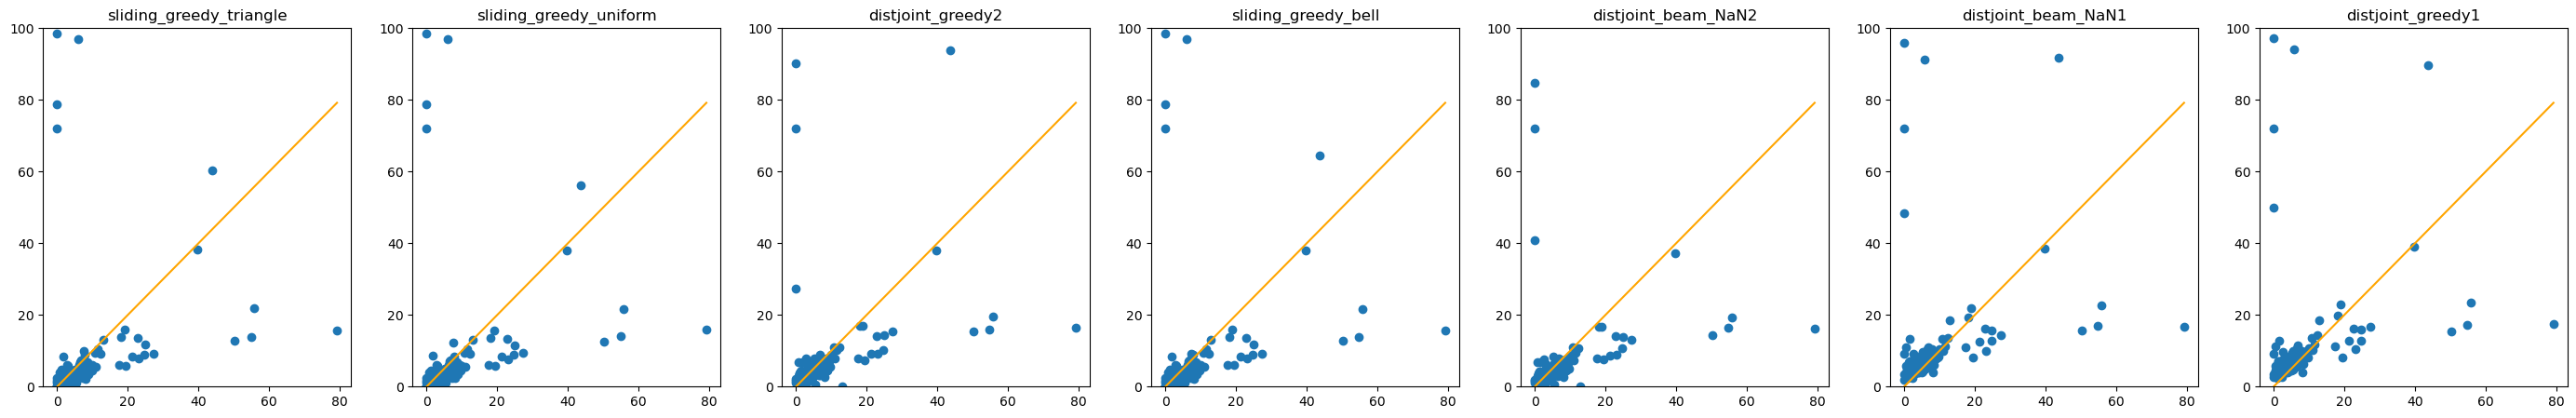

In [105]:
fig, ax = plt.subplots(1,len(pfiles),figsize=(len(pfiles)*5,5))
if type(ax) == matplotlib.axes._axes.Axes:
    ax = [ax]

for ip,pf in enumerate(pfiles):
    pfn = pf.split('/')[-1].split('.pickle')[0]
    ax[ip].plot(test_data['CER Orig'], test_data['CER ' + pfn], 'o')
    ax[ip].plot([test_data['CER Orig'].min(),test_data['CER Orig'].max()],[test_data['CER Orig'].min(),test_data['CER Orig'].max()], color='orange')
    ax[ip].set_ylim(0,100)
    pfn = pf.split('/')[-1].split('.pickle')[0]
    ax[ip].set_title(pfn)

In [108]:
len(test_data)

250

In [111]:
for ip,pf in enumerate(pfiles):
    pfn = pf.split('/')[-1].split('.pickle')[0]
    before = 'Orig'
    after = pfn
    print('********************', pfn, '*********************')

    print('--------- Before -------------')
    mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(test_data,'CER '+before, print_nans=True)
    print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
    mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(test_data,'WER '+before)
    print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
    print('')
    
    print('--------- After -------------')
    mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(test_data,'CER '+after)
    print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
    mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(test_data,'WER '+after)
    print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
    print('')
    
    # improvement
    #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
    print('------------ Improvement ----------------')
    mea_c,med_c,std_c,iqr_c = get_improvement_stats(test_data,'CER '+before, 'CER '+after)
    print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
    mea_w,med_w,std_w,iqr_w = get_improvement_stats(test_data,'WER '+before, 'WER '+after)
    print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
    # numbers of better and worse
    mask = test_data['CER '+before] < test_data['CER ' + after]
    print('CER : How many better =', len(test_data[~mask]), ', how many worse (or same) =', len(test_data[mask]), 
          ', % better =', round(len(test_data[~mask])/len(test_data)*100,2))
    mask = test_data['WER '+before] < test_data['WER ' + after]
    print('WER : How many better =', len(test_data[~mask]), ', how many worse (or same) =', len(test_data[mask]), 
         ', % better =', round(len(test_data[~mask])/len(test_data)*100,2))
    print('')
    print('')

******************** sliding_greedy_triangle *********************
--------- Before -------------
# NaNs = 0
CER : mean = 6.18 , std = 8.88 , median = 4.29 , iqr = 4.1
WER : mean = 15.18 , std = 10.13 , median = 15.46 , iqr = 14.25

--------- After -------------
CER : mean = 5.46 , std = 11.62 , median = 3.07 , iqr = 2.35
WER : mean = 14.15 , std = 13.49 , median = 11.2 , iqr = 7.62

------------ Improvement ----------------
CER : mean =  -1.03 , std = 128.17 , median = 26.3 , iqr = 41.72
WER : mean =  -37.32 , std = 255.51 , median = 23.17 , iqr = 56.29
CER : How many better = 194 , how many worse (or same) = 56 , % better = 77.6
WER : How many better = 169 , how many worse (or same) = 81 , % better = 67.6


******************** sliding_greedy_uniform *********************
--------- Before -------------
# NaNs = 0
CER : mean = 6.18 , std = 8.88 , median = 4.29 , iqr = 4.1
WER : mean = 15.18 , std = 10.13 , median = 15.46 , iqr = 14.25

--------- After -------------
CER : mean = 5.46 ,

Which one to use to save?

In [112]:
selection_alg = 'sliding_greedy_bell'

In [117]:
for ip,pf in enumerate(pfiles):
    pfn = pf.split('/')[-1].split('.pickle')[0]
    before = 'Orig'
    after = pfn
    if pfn == selection_alg:
        print('********************', pfn, '*********************')

        print('--------- Before -------------')
        mea_cbefore,med_cbefore,std_cbefore,iqr_cbefore = get_stats(test_data,'CER '+before, print_nans=True)
        print('CER : mean =', mea_cbefore, ', std =', std_cbefore, ', median =',med_cbefore, ', iqr =', iqr_cbefore)
        mea_wbefore,med_wbefore,std_wbefore,iqr_wbefore = get_stats(test_data,'WER '+before)
        print('WER : mean =', mea_wbefore, ', std =', std_wbefore, ', median =',med_wbefore, ', iqr =', iqr_wbefore)
        print('')

        print('--------- After -------------')
        mea_cafter,med_cafter,std_cafter,iqr_cafter = get_stats(test_data,'CER '+after)
        print('CER : mean =', mea_cafter, ', std =', std_cafter, ', median =',med_cafter, ', iqr =', iqr_cafter)
        mea_wafter,med_wafter,std_wafter,iqr_wafter = get_stats(test_data,'WER '+after)
        print('WER : mean =', mea_wafter, ', std =', std_wafter, ', median =',med_wafter, ', iqr =', iqr_wafter)
        print('')

        # improvement
        #improvement = lambda df: 100 * (1 - df.cer_after / df.cer_before)
        print('------------ Improvement ----------------')
        mea_c,med_c,std_c,iqr_c = get_improvement_stats(test_data,'CER '+before, 'CER '+after)
        print('CER : mean = ', mea_c, ', std =', std_c, ', median =',med_c, ', iqr =', iqr_c)
        mea_w,med_w,std_w,iqr_w = get_improvement_stats(test_data,'WER '+before, 'WER '+after)
        print('WER : mean = ', mea_w, ', std =', std_w, ', median =',med_w, ', iqr =', iqr_w)
        # numbers of better and worse
        mask = test_data['CER '+before] < test_data['CER ' + after] # CER should go down after correction -- cer before correction < cer after is wrong -- how many wrong?
        print('CER : How many better =', len(test_data[~mask]), ', how many worse (or same) =', len(test_data[mask]), 
              ', % better =', round(len(test_data[~mask])/len(test_data)*100,2))
        cerImp = round(len(test_data[~mask])/len(test_data)*100,2)
        mask = test_data['WER '+before] < test_data['WER ' + after]
        print('WER : How many better =', len(test_data[~mask]), ', how many worse (or same) =', len(test_data[mask]), 
             ', % better =', round(len(test_data[~mask])/len(test_data)*100,2))
        werImp = round(len(test_data[~mask])/len(test_data)*100,2)

******************** sliding_greedy_bell *********************
--------- Before -------------
# NaNs = 0
CER : mean = 6.18 , std = 8.88 , median = 4.29 , iqr = 4.1
WER : mean = 15.18 , std = 10.13 , median = 15.46 , iqr = 14.25

--------- After -------------
CER : mean = 5.48 , std = 11.7 , median = 3.09 , iqr = 2.37
WER : mean = 14.15 , std = 13.55 , median = 11.11 , iqr = 7.72

------------ Improvement ----------------
CER : mean =  -1.18 , std = 128.27 , median = 25.67 , iqr = 41.55
WER : mean =  -37.3 , std = 255.66 , median = 23.91 , iqr = 56.44
CER : How many better = 193 , how many worse (or same) = 57 , % better = 77.2
WER : How many better = 168 , how many worse (or same) = 82 , % better = 67.2


In [120]:
# save everything
dats = [mea_cbefore,mea_wbefore,mea_cafter,mea_wafter,
        mea_c,mea_w, cerImp, werImp]
names_start = 'windowed_only_words_'
datnames = ['mean_cer_before','mean_wer_before','mean_cer_after','mean_wer_after',
            'mean_cer_imp','mean_wer_imp', 'cerImp', 'werImp']
for d,n in zip(dats,datnames):
    save_dat(save_dats_dir+names_start+n+'.dat',d)